In [2]:
import pandas as pd
import numpy as np
from utils import utility
from utils.encoder import OneHotEncoder, ThermometerEncoder, IntegerEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2

In [3]:
col_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'class']
df = pd.read_csv('breast.csv',index_col=False, low_memory=False, header=None, names=col_names)
df = df.dropna()
df.corr()['class']

x1       0.714790
x2       0.820801
x3       0.821891
x4       0.706294
x5       0.690958
x6       0.822696
x7       0.758228
x8       0.718677
x9       0.423448
class    1.000000
Name: class, dtype: float64

In [4]:
ordinal_features = col_names[:-1] 
label = ['class']
ordinal_dic = {col : list(range(1, 10+1, 1)) for col in ordinal_features}
len(ordinal_dic)
df['class'].unique()
label_dic = {'class': list(df['class'].unique())}

In [5]:

df.to_csv('clean_dataset/breast/breast.csv', index=False)

In [6]:
feature_dic = {'ordinal': ordinal_dic, 'label': label_dic}
import pickle
with open('clean_dataset/breast/breast_dic.pkl', 'wb') as f:
    pickle.dump(feature_dic, f)

In [7]:
with open('clean_dataset/breast/breast_dic.pkl', 'rb') as f:
    aaaa = pickle.load(f)
aaaa

{'ordinal': {'x1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x2': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x3': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x4': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x5': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x6': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x7': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x8': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'x9': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
 'label': {'class': [1, 2]}}

Text(0.5, 1.0, 'Breast Cancer')

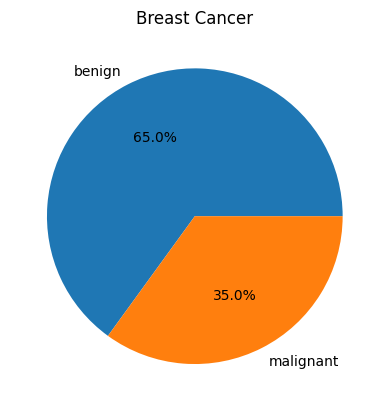

In [8]:
labels = [1,2]
sizes = [len(df[df['class'] == val]) for val in labels]
plt.pie(sizes, labels=['benign' if val == 1 else 'malignant' for val in labels], autopct='%1.1f%%')
plt.title('Breast Cancer')

In [9]:
res, models, res_train = utility.k_fold_validation(k=10, 
                  df=df, 
                  encoders=[OneHotEncoder, ThermometerEncoder, IntegerEncoder], 
                  pred_task=
                    {
                      'name': 'classification',
                      'model': LogisticRegression(C=0.04, max_iter=1000),
                      'metric': {'clf_rep': lambda y_true, y_pred: classification_report(y_true, y_pred, output_dict=True)}
                    }, 
                  features=
                    {
                      'ordinal': {
                        'name': ordinal_features,
                        'dict': ordinal_dic
                      }
                    },
                    return_model=True,
                    train_result=True)

c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

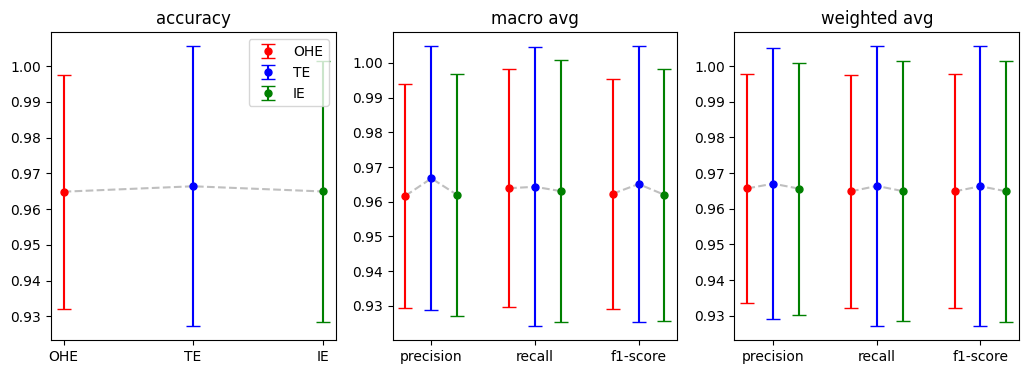

In [10]:
import matplotlib.pyplot as plt
import math
def deep_copy(dic):
    dic_res = {}
    for key, val in dic.items():
        dic_res[key] = deep_copy(val) if isinstance(val, dict) else val
    return dic_res
def round_decimal_places(df, d):
    dec = math.pow(10,d)
    df_copy = df.copy()
    df_copy = df_copy.map(lambda x: (math.ceil(x[0]*dec)/dec, math.ceil(x[1]*dec)/dec))
    return df_copy
res_temp = res
res_copy = deep_copy(res_temp)
d = 12
for encoder in res.keys():
    res_copy[encoder]['clf_rep']['accuracy'] = {key: res_temp[encoder]['clf_rep']['accuracy'] for key in res[encoder]['clf_rep']['macro avg'].keys()}
# df_lists = [pd.DataFrame(res_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns") for key in res_copy.keys()]
df_lists = [round_decimal_places(pd.DataFrame(res_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns").drop(index='support'), d) for key in res_copy.keys()]
plot_dic = {}
metrics = ['accuracy','macro avg', 'weighted avg']
inner_metrics = ['precision', 'recall', 'f1-score']

plot_dic = {}
for key in metrics:
    plot_dic[key] = {k: [] for k in inner_metrics}
    for key2 in inner_metrics:
        for dfs in df_lists:
            df_dict = dfs.to_dict()
            plot_dic[key][key2].append(list(df_dict[key][key2]))
            
            
modelss = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
model_names = ['OHE', 'TE', 'IE']
colors = ['r', 'b', 'g']
x_axis_placement = np.array([-0.25, 0, 0.25])
fig, ax = plt.subplots(1, 3, figsize=(12.5,4))
ax = ax.ravel()
for i, (key, val) in enumerate(plot_dic.items()):
    if key == 'accuracy':
        accs = np.array(val['precision'])
        ax[i].errorbar(range(len(accs)), accs[:,0], accs[:,1], alpha = 0.5, fmt='--', color = 'grey') 
        for j, (mean, std) in enumerate(accs):
            (_,caps,_)= ax[i].errorbar(j, accs[:,0][j], accs[:,1][j], label=model_names[j],color = colors[j], alpha = 1, fmt='.', markersize=10, capsize = 5) 
            for cap in caps:
                cap.set_markeredgewidth(1)
    else:  
        for j, (key2, val2) in enumerate(val.items()):
            model = np.array(val2)    
            x_axis=np.ones(len(model))*j
            ax[i].errorbar(x_axis + x_axis_placement, model[:,0], model[:,1], alpha = 0.5, fmt='--', color = 'grey')
            for k in range(len(x_axis)):
                (_,caps,_)= ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], label=model_names[k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) if j == 0 else ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) 
                for cap in caps:
                    cap.set_markeredgewidth(1)
for i, axe in enumerate(ax):
    axe.set_title(metrics[i])
    if metrics[i] == 'accuracy':
        axe.set_xticks(range(len(modelss)), model_names)
    else:
        axe.set_xticks(range(len(inner_metrics)), inner_metrics)

ax[0].legend()             
                

In [11]:
res

{'OneHotEncoder': {'clf_rep': {'1': {'precision': (0.9707488313718923,
     0.040640580094876824),
    'recall': (0.9654099563391716, 0.03350497107982697),
    'f1-score': (0.9677600481550444, 0.03348728185459193),
    'support': (44.4, 8.845337754998393)},
   '2': {'precision': (0.9526645505793303, 0.03718796651807053),
    'recall': (0.9623605052068674, 0.048240795184163944),
    'f1-score': (0.9568021555328057, 0.03546550831430444),
    'support': (23.9, 9.027181176868003)},
   'accuracy': (0.9648763853367435, 0.03272394368676917),
   'macro avg': {'precision': (0.9617066909756111, 0.03228960029033478),
    'recall': (0.9638852307730195, 0.03433032980063511),
    'f1-score': (0.962281101843925, 0.03316554839731738),
    'support': (68.3, 0.45825756949558394)},
   'weighted avg': {'precision': (0.9657120725089561, 0.03210506369332812),
    'recall': (0.9648763853367435, 0.03272394368676917),
    'f1-score': (0.9648688721898738, 0.03281179134445991),
    'support': (68.3, 0.4582575694

In [12]:
# import random
# from sklearn.model_selection import KFold
# k=10
# regr = LogisticRegression(max_iter=1000)
# test_pred_res, test_true_res = [], []
# train_pred_res, train_true_res = [], []
# # sc = StandardScaler()
# kf = KFold(k)   
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]
# for train_index, test_index in kf.split(df):
#     X_train, y_train, X_test, y_test = X.iloc[train_index], pd.DataFrame(y.iloc[train_index]), X.iloc[test_index], pd.DataFrame(y.iloc[test_index])
#     # random_train, random_test, _ = utility.encoding_pipeline(X_train[ordinal_features_plus], X_test[ordinal_features_plus], ThermometerEncoder, ordinal_dic_plus)
#     # nominal_train, nominal_test, _ = utility.encoding_pipeline(X_train[nominal_features], X_test[nominal_features], OneHotEncoder, nominal_dic)
#     ordinal_train, ordinal_test, _ = utility.encoding_pipeline(X_train[ordinal_features], X_test[ordinal_features], OneHotEncoder, ordinal_dic)
#     # other_train, other_test = np.array(X_train[other_features].values), np.array(X_test[other_features].values)
#     # sc.fit(other_train)
#     # other_train, other_test = sc.transform(other_train), sc.transform(other_test)
#     # y_train, y_test, _ = utility.encoding_pipeline(y_train, y_test, IntegerEncoder, label_dic)
#     # X_train_all, X_test_all = ordinal_train, ordinal_test
#     X_train_all, X_test_all = np.concatenate([ordinal_train], axis=1), np.concatenate([ordinal_test], axis=1)
#     # X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train, random_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test, random_test], axis=1)
#     regr.fit(X_train_all, y_train)
#     y_pred_test = regr.predict(X_test_all)
#     y_pred_train = regr.predict(X_train_all)
#     test_true_res = test_true_res+ [np.squeeze(y_test)] if len(test_true_res)> 0 else [np.squeeze(y_test)]
#     test_pred_res = test_pred_res+ [np.squeeze(y_pred_test)] if len(test_pred_res)> 0 else [np.squeeze(y_pred_test)]
#     train_true_res = train_true_res+ [np.squeeze(y_train)] if len(train_true_res)> 0 else [np.squeeze(y_train)]
#     train_pred_res = train_pred_res+ [np.squeeze(y_pred_train)] if len(train_pred_res)> 0 else [np.squeeze(y_pred_train)]

# test_temp_res, train_temp_res = [], []
# for i in range(k):
#     test_temp_res.append(classification_report(test_true_res[i], test_pred_res[i], output_dict=True)) 
#     train_temp_res.append(classification_report(train_true_res[i], train_pred_res[i], output_dict=True)) 
# clf_rep_dic_test, clf_rep_dic_train = utility.concat_dic(*test_temp_res), utility.concat_dic(*train_temp_res)
# test_res, train_res = utility.mean_std_dic(clf_rep_dic_test), utility.mean_std_dic(clf_rep_dic_train)

In [13]:
# train_res['accuracy'] , test_res['accuracy']

In [14]:
k=10
spec_dic = {key: [] for key in ordinal_dic.keys()}
for i in range(k):
    ohe_1 = models['OneHotEncoder'][i]
    te_1 = models['ThermometerEncoder'][i]
    ie_1 = models['IntegerEncoder'][i]

    ord_coef_dic = utility.create_coef_dic(0, ordinal_dic, ordinal_features, ohe_1.coef_,te_1.coef_)
    ord_coef_dic_cum = {key: [val[0]]+[np.cumsum(val[1])] for key, val in ord_coef_dic.items()}
    for key, val in ord_coef_dic_cum.items():
        spec_dic[key] += [np.corrcoef(val)[0][1]]
spec_dic_mean_std = {key : (np.mean(val), np.std(val)) for key, val in spec_dic.items()}   

In [26]:
spec_dic_mean_std

{'x1': (0.9245497382582493, 0.005967386275669491),
 'x2': (0.8413472700927056, 0.006433538675423467),
 'x3': (0.8821021717935039, 0.007325595767744295),
 'x4': (0.7709527195162635, 0.009809700007167547),
 'x5': (0.6786113202187432, 0.009216464613192341),
 'x6': (0.795281377796854, 0.008445886890261925),
 'x7': (0.8747647211842315, 0.005722381231323768),
 'x8': (0.8191624764795415, 0.010545978216761887),
 'x9': (0.5983404876490858, 0.012876626242085102)}

Text(0, 0.5, 'correlation')

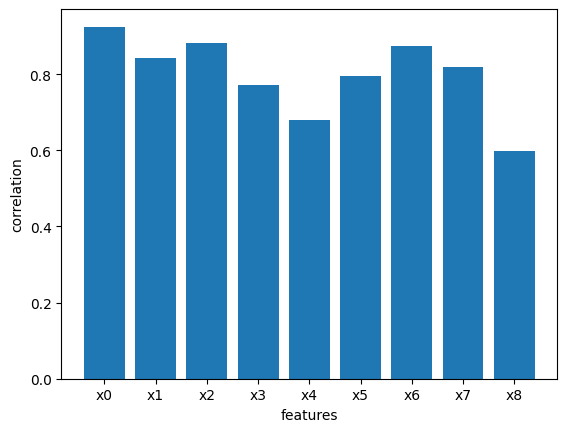

In [25]:
spec_plot = {key: val[0] for key, val in spec_dic_mean_std.items()}
plt.bar([f'x{i}' for i in range(len(spec_plot))], spec_plot.values())
plt.xlabel('features')
plt.ylabel('correlation')

In [17]:
# other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic.values()])

all_ohe_coef = np.array([models['OneHotEncoder'][i].coef_ for i in range(k)]).squeeze()
all_te_coef = np.array([models['ThermometerEncoder'][i].coef_ for i in range(k)]).squeeze()
# all_te_coef_cumsum = [np.cumsum(all_te_coef[:, other_num+nom_num:], axis=1) for i in [len(val) for val in ordinal_dic.values()]]
all_te_coef_cumsum = []
s=0
for i in [len(val) for val in ordinal_dic.values()]:
    all_te_coef_cumsum.append(np.cumsum(all_te_coef[:, s:s+i], axis=1))
    s+=i
all_te_coef_cumsum = np.concatenate(tuple(all_te_coef_cumsum), axis=1)
all_ie_coef = np.array([models['IntegerEncoder'][i].coef_ for i in range(k)]).squeeze()


all_ohe_coef_mean = np.mean(all_ohe_coef, axis=0)
# all_te_coef_mean = np.array(list(np.mean(all_te_coef, axis=0)[:other_num+nom_num]) + list(np.mean(all_te_coef_cumsum, axis=0)))
all_te_coef_mean = np.mean(all_te_coef_cumsum, axis=0)
all_ie_coef_mean = np.mean(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic.values()]):
    print([all_ie_coef_mean[idx]])
    all_ie_coef_temp.append(np.array([all_ie_coef_mean[idx]]*i)*np.linspace(1,i,i))
all_ie_coef_mean = np.concatenate(tuple(all_ie_coef_temp))
# all_ie_coef_mean = np.concatenate((all_ie_coef_mean, all_ie_coef_temp))

# all_ohe_coef_mean = StandardScaler().fit_transform(all_ohe_coef_mean.reshape(-1, 1)).squeeze()
# all_te_coef_mean = StandardScaler().fit_transform(all_te_coef_mean.reshape(-1, 1)).squeeze()
# all_ie_coef_mean = StandardScaler().fit_transform(all_ie_coef_mean.reshape(-1, 1)).squeeze()

all_ohe_coef_std = np.std(all_ohe_coef, axis=0)
all_te_coef_std = np.std(all_te_coef_cumsum, axis=0)
all_ie_coef_std = np.std(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic.values()]):
    all_ie_coef_temp.append(np.array([all_ie_coef_std[idx]]*i)*np.array([1]*i))
all_ie_coef_std = np.concatenate(tuple(all_ie_coef_temp))

[0.39565059412570525]
[0.1469597121904961]
[0.2399443644952039]
[0.2231233212933283]
[0.1114354305654119]
[0.34738319061737416]
[0.28609792289218017]
[0.19093360522535724]
[0.20246475936345343]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


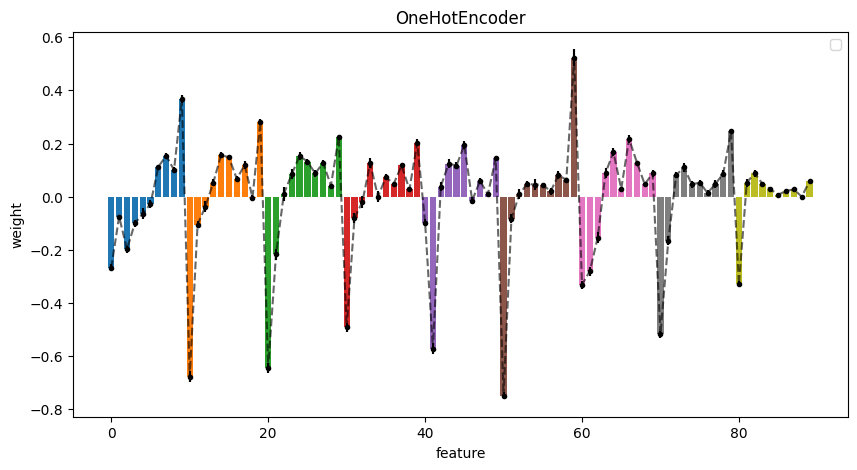

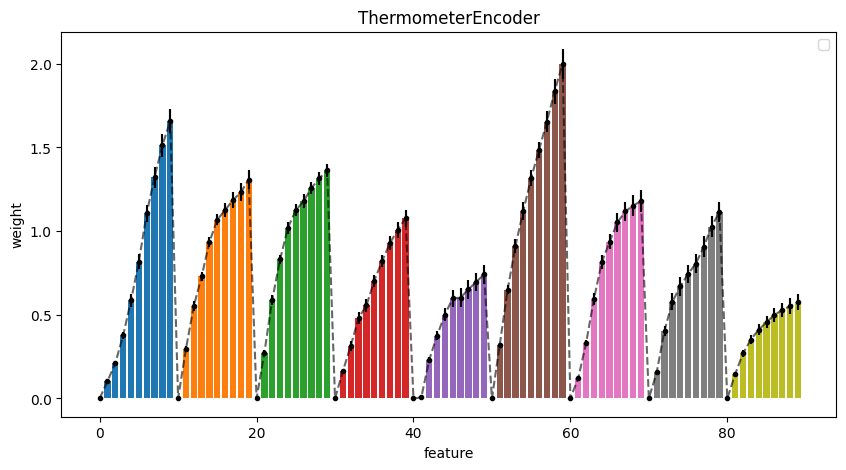

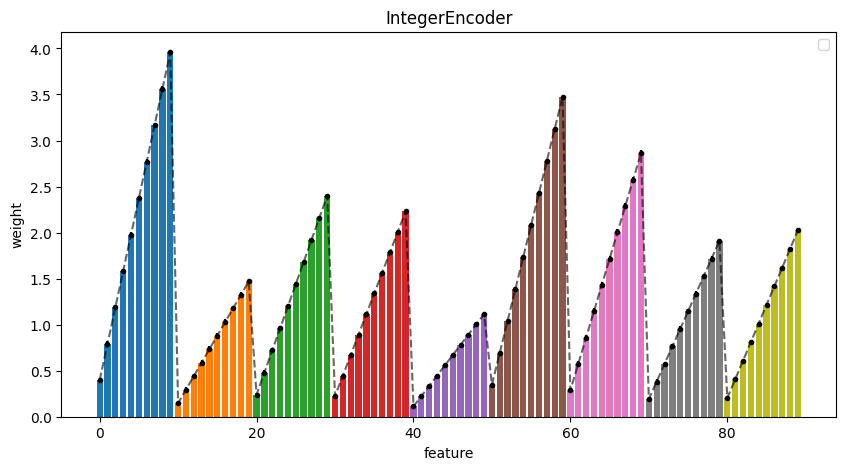

In [18]:
import matplotlib.pyplot as plt
title = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
label = ['Numerical', 'Nominal', 'Ordinal']
for idx, (all_mean, all_std) in enumerate(zip([all_ohe_coef_mean, all_te_coef_mean, all_ie_coef_mean], [all_ohe_coef_std, all_te_coef_std, all_ie_coef_std])):
    plt.figure(figsize=(10,5))
    start_2 = 0
    for j in [len(val) for val in ordinal_dic.values()]:  
        plt.bar(range(len(all_mean))[start_2:start_2+j], all_mean[start_2:start_2+j])
        start_2 += j
        
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='.')
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='--', alpha=0.6)
    plt.title(title[idx])
    plt.ylabel('weight'), plt.xlabel('feature')
    plt.legend()


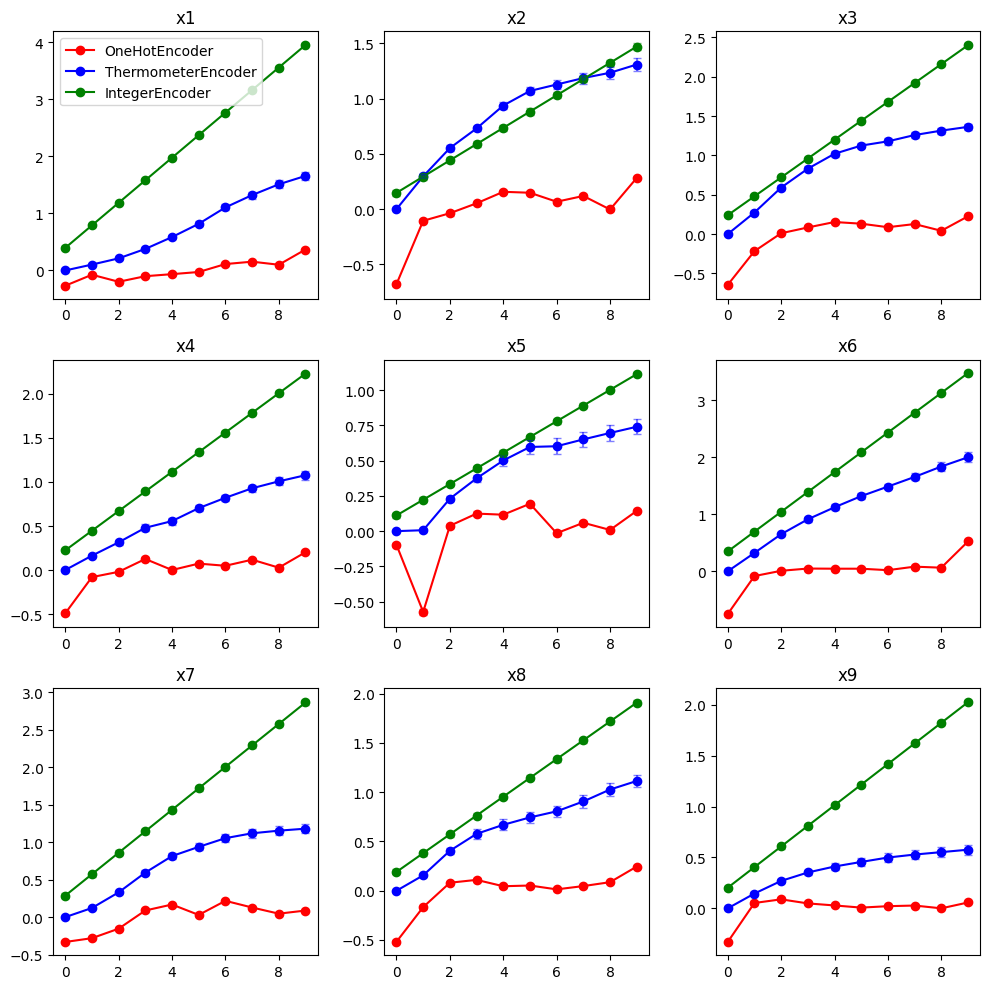

In [29]:
import matplotlib.pyplot as plt
import math
label=['OneHotEncoder', 'ThermometerEncoder', 'IntegerEncoder']
color = ['r', 'b', 'g']
keys = list(ordinal_dic.keys())
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax=ax.ravel()
ord_num_list = [len(val) for val in ordinal_dic.values()]
# fig.suptitle('ordinal')
start = 0
for i, axe in enumerate(ax.ravel()):
    cur_len = ord_num_list[i] 
    cur_list = range(cur_len)
    axe.plot(cur_list, all_ohe_coef_mean[start: start+cur_len], label = label[0], color=color[0], marker='o')
    axe.plot(cur_list, all_te_coef_mean[start: start+cur_len], label = label[1], color=color[1], marker='o')
    axe.plot(cur_list, all_ie_coef_mean[start: start+cur_len], label = label[2], color=color[2], marker='o')
    (_,caps1,_) = axe.errorbar(cur_list, all_ohe_coef_mean[start: start+cur_len], all_ohe_coef_std[start: start+cur_len],alpha = 0.5,color=color[0], fmt='.', capsize = 3)
    (_,caps2,_) = axe.errorbar(cur_list, all_te_coef_mean[start: start+cur_len], all_te_coef_std[start: start+cur_len],alpha = 0.5, color=color[1], fmt='.', capsize = 3)
    (_,caps3,_) = axe.errorbar(cur_list, all_ie_coef_mean[start: start+cur_len], all_ie_coef_std[start: start+cur_len],alpha = 0.5, color=color[2], fmt='.', capsize = 3)
    for cap in caps1+caps2+caps3:
        cap.set_markeredgewidth(1)
    axe.set_title(keys[i])
    axe.set_ylabel('weight')
    axe.set_xlabel('features')
    start += cur_len
ax[0].legend()     
plt.tight_layout()

In [21]:
ax

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

In [9]:

with open('breast_result/breast_cv_3.csv','w') as f:
    for df in df_lists:
        f.write(f"{df.columns.name}\n")
        df.to_csv(f)
        f.write("\n")

In [ ]:
import numpy as np

def concat_dic(*dic_list):
    res_dic = dic_list[0].copy()
    for key in res_dic.keys():
        temp_res = []
        for dic in dic_list:
            temp_res.append(dic[key])
        res_dic[key] = concat_dic(*temp_res) if isinstance(res_dic[key], dict) else temp_res
    
    return res_dic
        

In [ ]:
def eval_dic(dic):
    res_dic = dic
    for key, val in res_dic.items():
        res_dic[key] = concat_dic(val) if isinstance(val, dict) else (np.mean(val), np.std(val))

    return res_dic